In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.table import Table

%matplotlib inline

# Verner cross-sections from VizieR

http://astroquery.readthedocs.io/en/latest/vizier/vizier.html

In [2]:
from astroquery.vizier import Vizier

In [3]:
# should work when connected to internet and VizieR website is working
try:
    TABLE_NAME = 'J/A+AS/109/125/table1'
    Vizier.ROW_LIMIT = -1
    vy1995 = Vizier.get_catalogs(TABLE_NAME)[TABLE_NAME]
    vy1995.write('VY1995_vizier.txt', format='ascii', overwrite=True)
# if not, open the saved file
except:
    vy1995 = Table.read('VY1995_vizier.txt')

In [4]:
def get_element(z, ion=None, shell=None):
    """
    Returns
    -------
    Boolean array that filters the Verner & Yaklovev 1995 table of analytic formulae 
    for atomic photoelectric absorption cross-sections.
    
    Inputs
    ------
    z : int
        Atomic number
        
    ion : int
        Ion state (0 = neutral, 1 = singly ionized, etc..)
        The default (None) will return a filter for any ion state of 
        element with atomic number `z`
    
    shell : int
        The Principle quantum number of the shell. Default (1)
    """
    result = (vy1995['Z'] == z)
    
    if ion is not None:
        assert (ion >= 0) and (ion < z)
        n_electrons = z - ion
        result = result & (vy1995['N'] == n_electrons)
    
    if shell is not None:
        result = result & (vy1995['n'] == shell)
    
    return result

In [5]:
np.max(vy1995['Z'])

30

In [6]:
vy1995[get_element(8, 0)]

Z,N,n,l,E_th_,E_0_,sigma_0_,y_a_,P,y_w_
,,,,eV,eV,Mbarn,,,
int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32
8,8,2,1,13.6,13.9,1.22e+05,1.36,11.4,0.41
8,8,2,0,28.5,19.9,242,3.24,8.04,0
8,8,1,0,538,177,32.4,381,1.08,0


Equation 1 of [Verner & Yaklovev 1995](http://adsabs.harvard.edu/abs/1995A%26AS..109..125V)

$$ \sigma_{nl} = \sigma_0 F(E/E_0) ~ {\rm Mb} $$

where

$$ F(y) = [(y-1)^2+ y_w^2] ~ y^{-Q} ~ \left( 1 + \sqrt{y/y_a} \right)^{-P} $$

where

$$ Q = 5.5 + l - 0.5 P $$

where $l$ is the subshell orbital quantum number (e.g., 0, 1, 2 for s, p, d, respectively).

The parameters $\sigma_0$, $y_a$, $y_w$, and $P$ are provided by the tables.

In [7]:
u.Mbarn.to('cm^2')

9.999999999999999e-19

In [8]:
def _compute_xsect_from_row(egrid, row):
    Z, N, n, l, E_th, E_0, sigma_0, y_a, P, y_w = row
    #print(Z, N, n, l, E_th, E_0, sigma_0, y_a, P, y_w)
    
    # VY1995 formula
    y = egrid.to('eV') / (E_0 * u.eV)
    Q = 5.5 + l - 0.5 * P
    F = ((y-1.)**2 + y_w**2) * np.power(y, -Q) * np.power((1. + np.sqrt(y/y_a)), -P)
    formula = sigma_0 * u.Mbarn * F
    
    # everything below the threshold energy is zero
    efilt   = egrid.to('eV').value > E_th
    result  = np.zeros(len(egrid)) * u.Mbarn
    result[efilt] = formula[efilt]
    return result

In [9]:
def compute_xsect(egrid, z, ion=None, shell=None):
    """
    Returns
    -------
    astropy.units.Quantity (array, units of 'Mbarn')
        Returns the total photoelectric absorption cross-section computed for
        the user specified element, ion(s), and shell(s).

    Inputs
    ------
    egrid : astropy.units.Quantity (array)
        Energy values for which to compute the cross-sections

    z : int
        Atomic number

    ion : int
        Ion state (0 = neutral, 1 = singly ionized, etc..)
        The default (None) will return a filter for any ion state of
        element with atomic number `z`.

    shell : int
        The Principle quantum number of the shell. 
        The default (None) will return a filter for any shell with
        atomic number `z`.
    """
    result = np.zeros(len(egrid)) * u.Mbarn
    filt   = get_element(z, ion=ion, shell=shell)
    rows   = vy1995[filt]
    for r in rows:
        result += _compute_xsect_from_row(egrid, r)
    return result

In [10]:
EGRID = np.logspace(-1, 1, 1000) * u.keV

OI_K_par = vy1995[get_element(8, 0, 1)]
OI_K = _compute_xsect_from_row(EGRID, OI_K_par[0])

In [11]:
OI = compute_xsect(EGRID, 8, 0)

In [12]:
O = compute_xsect(EGRID, 8)

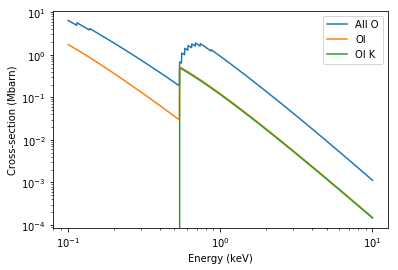

In [13]:
plt.plot(EGRID, O.to('Mbarn'), label='All O')
plt.plot(EGRID, OI.to('Mbarn'), label='OI')
plt.plot(EGRID, OI_K.to('Mbarn'), label='OI K')
plt.loglog()
plt.xlabel('Energy ({})'.format(EGRID.unit))
plt.ylabel('Cross-section (Mbarn)')
plt.legend(loc='upper right')